# Import LIbraries

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from PIL import Image
from pathlib import Path

# Method to check video paths

In [2]:

# def count_files_if_exists(real_path, manipulated_path):
#     for label, path in {'Real': real_path, 'Manipulated': manipulated_path}.items():
#         if not os.path.exists(path):
#             print(f"Error: {label} path does not exist -> {path}")
#             return
#         print(f"{label} files: {len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])}")


# Output paths

In [3]:
output_real_dir_train = "/kaggle/input/frames/frames/train/real"
output_real_dir_validation = "/kaggle/input/frames/frames/validation/real"
output_real_dir_test = "/kaggle/input/frames/frames/test/real"

output_manipulated_dir_train = "/kaggle/input/frames/frames/train/manipulated"
output_manipulated_dir_validation = "/kaggle/input/frames/frames/validation/manipulated"
output_manipulated_dir_test = "/kaggle/input/frames/frames/test/manipulated"


# def ensure_dirs_exist(*dirs):
#     [os.makedirs(d, exist_ok=True) for d in dirs]

# ensure_dirs_exist(
#     output_real_dir_train,
#     output_real_dir_validation,
#     output_real_dir_test,
#     output_manipulated_dir_train,
#     output_manipulated_dir_validation,
#     output_manipulated_dir_test
# )

In [4]:

# # Function to count files in a directory
# def count_files(directory):
#     if os.path.exists(directory):
#         return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
#     else:
#         return 0

# # Count and print results
# print("Real - Train:", count_files(output_real_dir_train))
# print("Real - Validation:", count_files(output_real_dir_validation))
# print("Real - Test:", count_files(output_real_dir_test))

# print("Manipulated - Train:", count_files(output_manipulated_dir_train))
# print("Manipulated - Validation:", count_files(output_manipulated_dir_validation))
# print("Manipulated - Test:", count_files(output_manipulated_dir_test))

# Frame extraction method

In [5]:
# def extract_frames_from_videos(videos_dir, output_dir, label, skip=0, max_videos=1000):
#     video_files = [f for f in os.listdir(videos_dir) if f.endswith('.mp4')]
#     video_files = video_files[skip:skip + max_videos]  # Apply skip and limit

#     for video_file in video_files:
#         video_path = os.path.join(videos_dir, video_file)
#         cap = cv2.VideoCapture(video_path)
#         frame_count = 0
#         success, image = cap.read()

#         while success:
#             fps = int(cap.get(cv2.CAP_PROP_FPS)) or 1  # fallback to 1 if FPS is 0
#             if frame_count % fps == 0:
#                 frame_filename = f"{label}_{video_file}_frame{frame_count // fps}.jpg"
#                 frame_path = os.path.join(output_dir, frame_filename)
#                 cv2.imwrite(frame_path, image)
#             success, image = cap.read()
#             frame_count += 1

#         cap.release()

# Extract train videos

In [6]:
print("Extracting real videos.........")
# extract_frames_from_videos(real_videos_dir, output_real_dir_train, "real",skip=0, max_videos=800) 
print("Extraction completed")
print("Extracting manipulated videos.........")
# extract_frames_from_videos(manipulated_videos_dir, output_manipulated_dir_train, "manipulated",skip=0, max_videos=800)
print("Extraction completed")

Extracting real videos.........
Extraction completed
Extracting manipulated videos.........
Extraction completed


# Extract validation videos

In [7]:
print("Extracting real videos.........")
# extract_frames_from_videos(real_videos_dir, output_real_dir_validation, "real",skip=800, max_videos=100)
print("Extraction completed")
print("Extracting manipulated videos.........")
# extract_frames_from_videos(manipulated_videos_dir, output_manipulated_dir_validation, "manipulated",skip=800, max_videos=100)
print("Extraction completed")

Extracting real videos.........
Extraction completed
Extracting manipulated videos.........
Extraction completed


# Extract test videos

In [8]:
print("Extracting real videos.........")
# extract_frames_from_videos(real_videos_dir, output_real_dir_test, "real",skip=900, max_videos=100)
print("Extraction completed")
print("Extracting manipulated videos.........")
# extract_frames_from_videos(manipulated_videos_dir, output_manipulated_dir_test, "manipulated",skip=900, max_videos=100)
print("Extraction completed")

Extracting real videos.........
Extraction completed
Extracting manipulated videos.........
Extraction completed


# vit_large_patch16_224

In [9]:
%%capture
pip install timm

In [10]:
import os
import glob
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from timm.data.mixup import Mixup
from timm.scheduler import CosineLRScheduler
import timm


In [11]:
BATCH_SIZE = 32
EPOCHS = 50
LR = 3e-4
IMG_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE: ', DEVICE)
dataset_dir_train = "/kaggle/input/frames/frames/train"
dataset_dir_validation = "/kaggle/input/frames/frames/validation"
dataset_dir_test = "/kaggle/input/frames/frames/test"

class_to_idx = {'manipulated': 0, 'real': 1}


DEVICE:  cuda


In [12]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]



In [14]:
def load_image_paths_and_labels(dataset_dir):
    image_paths, labels = [], []
    class_to_idx = {cls: idx for idx, cls in enumerate(os.listdir(dataset_dir)) if os.path.isdir(os.path.join(dataset_dir, cls))}

    for cls, idx in class_to_idx.items():
        paths = glob.glob(os.path.join(dataset_dir, cls, "*.*"))
        for path in paths:
            if path.lower().endswith(('.jpg', '.png', '.jpeg', '.webp', '.tiff')):
                image_paths.append(path)
                labels.append(idx)
    
    return image_paths, labels




In [15]:
train_paths, train_labels = load_image_paths_and_labels(dataset_dir_train)
val_paths, val_labels = load_image_paths_and_labels(dataset_dir_validation)

train_ds = CustomImageDataset(train_paths, train_labels, transform=train_transform)
val_ds = CustomImageDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from timm.scheduler import CosineLRScheduler
from timm.data.mixup import Mixup
import matplotlib.pyplot as plt

# 🧠 Model setup
model = timm.create_model("inception_resnet_v2", pretrained=True, num_classes=2)
model = model.to(DEVICE)

# ⚙️ Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = CosineLRScheduler(optimizer, t_initial=EPOCHS)

# 🔀 Mixup/CutMix config
mixup_fn = Mixup(
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
    prob=0.8,
    switch_prob=0.5,
    label_smoothing=0.1,
    num_classes=2
)

# 📊 Tracking variables
best_val_acc = 0
best_train_acc = 0  
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []


print(f"\n\n\n🏋️ Training Started......")

# 🏋️ Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x, y = mixup_fn(x, y)
        outputs = model(x)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        _, targets = torch.max(y, 1)
        correct += (preds == targets).sum().item()

    train_acc = 100 * correct / len(train_loader.dataset)
    avg_train_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")

    # ✅ Validation
    model.eval()
    val_correct = 0
    val_loss = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y).sum().item()

    val_acc = 100 * val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    print(f"[Epoch {epoch+1}] Validation Loss: {avg_val_loss:.4f} | Validation Acc: {val_acc:.2f}%")

    # ✅ Save history
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # ✅ Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_inception_resnet_v2.pth") 

    scheduler.step(epoch) 

print(f"\n✅ Best Validation Accuracy: {best_val_acc:.2f}%") 
best_train_acc = max(train_accuracies)
print(f"\n✅ Best Training Accuracy: {best_train_acc:.2f}%")





🏋️ Training Started......
[Epoch 1] Train Loss: 0.6547 | Train Acc: 64.43%
[Epoch 1] Validation Loss: 0.9922 | Validation Acc: 71.52%
[Epoch 2] Train Loss: 0.5756 | Train Acc: 77.13%
[Epoch 2] Validation Loss: 0.4891 | Validation Acc: 81.10%
[Epoch 3] Train Loss: 0.5467 | Train Acc: 80.79%
[Epoch 3] Validation Loss: 0.4814 | Validation Acc: 82.22%
[Epoch 4] Train Loss: 0.5307 | Train Acc: 82.91%
[Epoch 4] Validation Loss: 0.4706 | Validation Acc: 82.25%
[Epoch 5] Train Loss: 0.5274 | Train Acc: 82.87%
[Epoch 5] Validation Loss: 0.4401 | Validation Acc: 85.46%
[Epoch 6] Train Loss: 0.5092 | Train Acc: 85.07%
[Epoch 6] Validation Loss: 0.4389 | Validation Acc: 85.87%
[Epoch 7] Train Loss: 0.5042 | Train Acc: 86.12%
[Epoch 7] Validation Loss: 0.4605 | Validation Acc: 83.13%
[Epoch 8] Train Loss: 0.5071 | Train Acc: 85.73%
[Epoch 8] Validation Loss: 0.4141 | Validation Acc: 86.86%
[Epoch 9] Train Loss: 0.4996 | Train Acc: 86.28%
[Epoch 9] Validation Loss: 0.6066 | Validation Acc: 76.10%

In [17]:
print(f"\n\nTraining Losses:\n\n")
print(train_losses)

print(f"\n\nValidation Losses:\n\n")
print(val_losses)

print(f"\n\nTraining Accuracies:\n\n")
print(train_accuracies)

print(f"\n\nValidation Accuracies:\n\n")
print(val_accuracies)



Training Losses:


[0.6546588296017039, 0.5756104521668006, 0.5466988795578726, 0.5306800094283657, 0.5273630844712748, 0.509225133024616, 0.5042348205123419, 0.5070537249921772, 0.49956581113024506, 0.49438083441659747, 0.5013028106694359, 0.4912111651566293, 0.4836858636987062, 0.49832368755536804, 0.4840357794805809, 0.4849355274144514, 0.48806070168445137, 0.4863407784160763, 0.48137123085589073, 0.473989336456291, 0.4734220813515255, 0.4747319349352224, 0.4767231942756186, 0.4693890707299052, 0.47464047749469307, 0.4657435855931706, 0.4688235732876224, 0.47096607251545036, 0.4689125385549333, 0.4676835566084571, 0.46507104231742186, 0.46953267699161183, 0.4609537720373629, 0.45402210561458956, 0.46649160306640125, 0.4657106402908824, 0.46316798669075276, 0.4630638715109707, 0.45988370484285396, 0.4582834529533308, 0.45903288410524284, 0.45129197612098215, 0.4614830639197993, 0.45783461936952646, 0.4530625185726111, 0.46327687131524575, 0.46039528832023524, 0.45066325936788393, 0

# Loss & Accuracy Curve

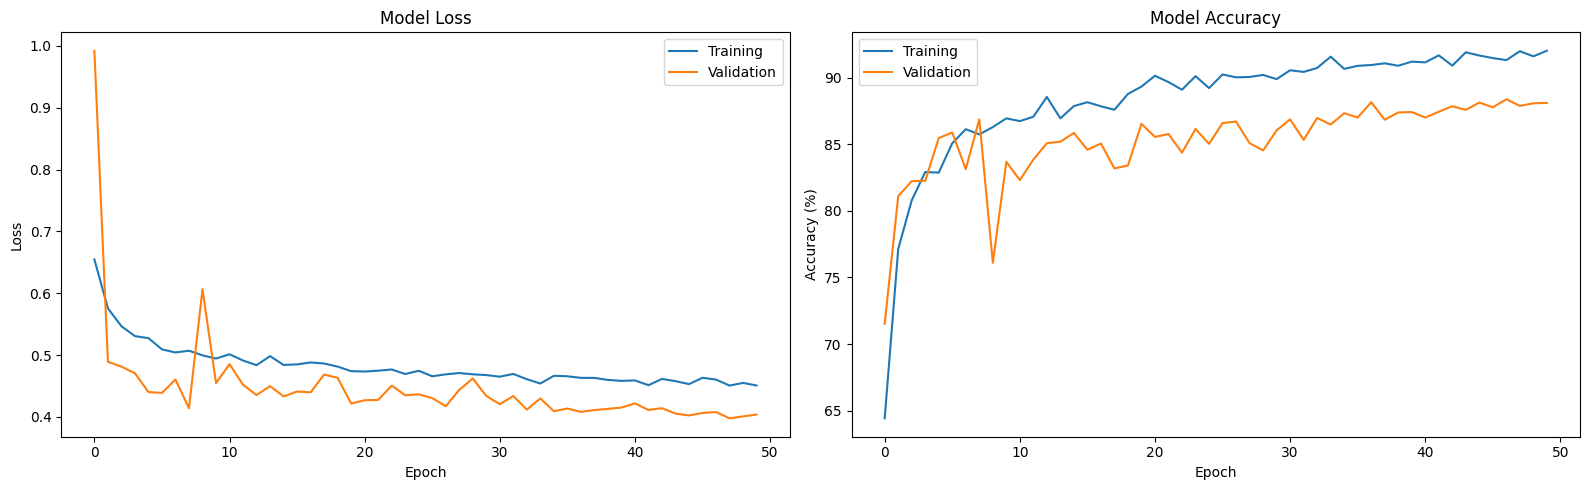

In [18]:
import matplotlib.pyplot as plt

# ✅ Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 📉 Loss Curve
axes[0].plot(train_losses, label='Training')
axes[0].plot(val_losses, label='Validation')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(False)

# 📈 Accuracy Curve
axes[1].plot(train_accuracies, label='Training')
axes[1].plot(val_accuracies, label='Validation')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()


# Test Script

In [19]:
from collections import defaultdict
import torch.nn.functional as F
import os
import re
def extract_video_name(frame_path):
    filename = os.path.basename(frame_path)
    
    if "manipulated" in filename:
        number_part = re.search(r'manipulated_(\d+)', filename)
        if number_part:
            return f"{number_part.group(1).zfill(3)}_manipulated"
    elif "real" in filename:
        number_part = re.search(r'real_(\d+)', filename)
        if number_part:
            return f"{number_part.group(1).zfill(3)}_real"
    
    return "000_unknown"

test_paths, test_labels = load_image_paths_and_labels(dataset_dir_test)

# Create dataset and loader
test_ds = CustomImageDataset(test_paths, test_labels, transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Load model
model = timm.create_model("inception_resnet_v2", pretrained=True, num_classes=2)
model.load_state_dict(torch.load("best_model_inception_resnet_v2.pth"))
model = model.to(DEVICE)
model.eval()

video_preds = defaultdict(list)
video_labels = {}

with torch.no_grad():
    idx = 0  # global index to track current frame
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        outputs = model(x)
        probs = F.softmax(outputs, dim=1)[:, 1]  # class "real" probability

        batch_size = x.size(0)
        for i in range(batch_size):
            frame_path = test_ds.paths[idx]
            video_id = extract_video_name(frame_path)

            video_preds[video_id].append(probs[i].item())
            video_labels[video_id] = y[i].item()

            idx += 1  # move to next frame

# Video-level accuracy
correct = 0
total = 0

for video_id, probs in video_preds.items():
    avg_prob = sum(probs) / len(probs)
    pred_label = 1 if avg_prob >= 0.5 else 0
    true_label = video_labels[video_id]

    if pred_label == true_label:
        correct += 1
    total += 1

video_accuracy = 100 * correct / total
print(f"Video-level Accuracy: {video_accuracy:.2f}%")


Video-level Accuracy: 93.00%


# Classification Report

In [20]:
from sklearn.metrics import classification_report

# Prepare video-level true and predicted labels
y_true = []
y_pred = []

for video_id, probs in video_preds.items():
    avg_prob = sum(probs) / len(probs)
    pred_label = 1 if avg_prob >= 0.5 else 0
    true_label = video_labels[video_id]

    y_true.append(true_label)
    y_pred.append(pred_label)

# Classification report
target_names = ['Manipulated', 'Real']  # 0 = manipulated, 1 = real
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("📄 Classification Report for Test::\n")
print(report)


📄 Classification Report for Test::

              precision    recall  f1-score   support

 Manipulated     0.9135    0.9500    0.9314       100
        Real     0.9479    0.9100    0.9286       100

    accuracy                         0.9300       200
   macro avg     0.9307    0.9300    0.9300       200
weighted avg     0.9307    0.9300    0.9300       200



# Confusion Matrix

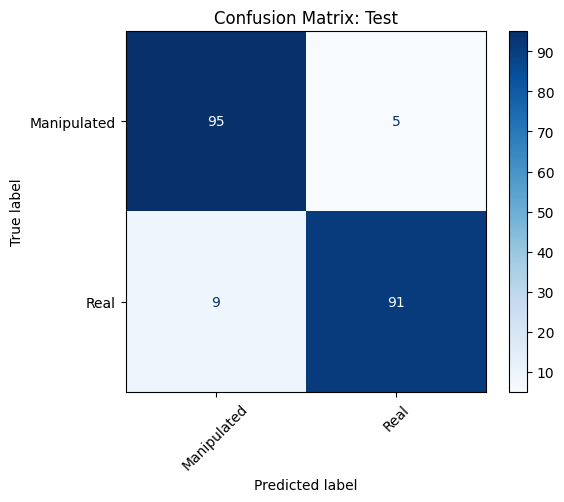

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Gather all ground truths and predictions
y_true = []
y_pred = []

for video_id, probs in video_preds.items():
    avg_prob = sum(probs) / len(probs)
    pred_label = 1 if avg_prob >= 0.5 else 0
    true_label = video_labels[video_id]

    y_true.append(true_label)
    y_pred.append(pred_label)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Manipulated", "Real"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.set_title("Confusion Matrix: Test")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ROC Curve

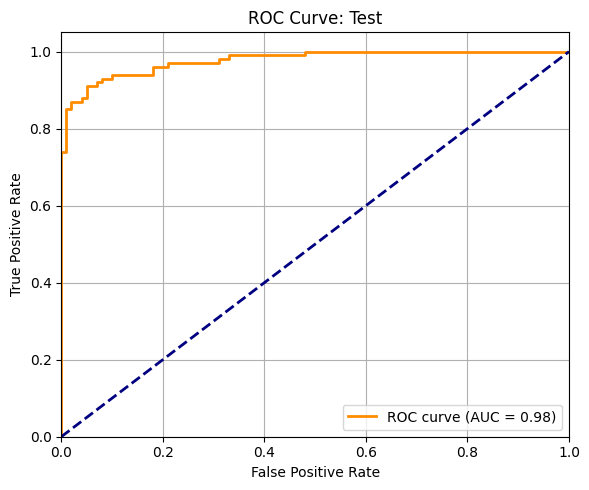

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Collect true labels and predicted probabilities
y_true = []
y_score = []

for video_id, probs in video_preds.items():
    avg_prob = sum(probs) / len(probs)  # probability of class "real"
    true_label = video_labels[video_id]

    y_true.append(true_label)
    y_score.append(avg_prob)  # keep raw probability for ROC

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Test')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
